In [1]:
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)

# DATA

In [2]:
# Define a transform to normalize the data (Preprocessing) and cast to tensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True,
                          train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True,
                         train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


print(trainloader.dataset)
print(testloader.dataset)

0.5%

100.0%


Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw


102.8%


Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw




100.0%


Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



112.7%

Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


Text(0.5, 1.0, '6')

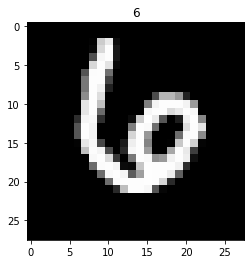

In [3]:
imgs, labels = iter(trainloader).next()

# visualize
plt.imshow(imgs[0].squeeze(), cmap = 'Greys_r')
plt.title(f'{labels[0]}')

# Model

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.fc1 = nn.Linear(64*7*7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
        # dropout to reduce overfitting
        self.dropout = nn.Dropout2d(p=0.20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten
        x = x.view(x.shape[0], -1)

        # activation function
        layer1 = self.dropout(F.relu(self.fc1(x)))
        layer2 = self.dropout(F.relu(self.fc2(layer1)))
        out = F.log_softmax(self.fc3(layer2), dim=1)
        
        return out

model = ConvNet()
model(imgs).shape

c:\Users\ritth\software\anaconda\envs\deep\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


torch.Size([64, 10])

# Training and validation

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Epoch 1/15
Train loss: 0.9489
Test accuracy: 98.00%
Epoch 2/15
Train loss: 0.8632
Test accuracy: 98.65%
Epoch 3/15
Train loss: 0.8573
Test accuracy: 98.98%
Epoch 4/15
Train loss: 0.8525
Test accuracy: 99.09%
Epoch 5/15
Train loss: 0.8411
Test accuracy: 98.85%
Epoch 6/15
Train loss: 0.8480
Test accuracy: 99.04%
Epoch 7/15
Train loss: 0.8374
Test accuracy: 99.05%
Epoch 8/15
Train loss: 0.8393
Test accuracy: 98.75%
Epoch 9/15
Train loss: 0.8371
Test accuracy: 99.10%
Epoch 10/15
Train loss: 0.8428
Test accuracy: 98.97%
Epoch 11/15
Train loss: 0.8328
Test accuracy: 99.18%
Epoch 12/15
Train loss: 0.8406
Test accuracy: 99.23%
Epoch 13/15
Train loss: 0.8309
Test accuracy: 99.13%
Epoch 14/15
Train loss: 0.8264
Test accuracy: 99.15%
Epoch 15/15
Train loss: 0.8370
Test accuracy: 98.99%


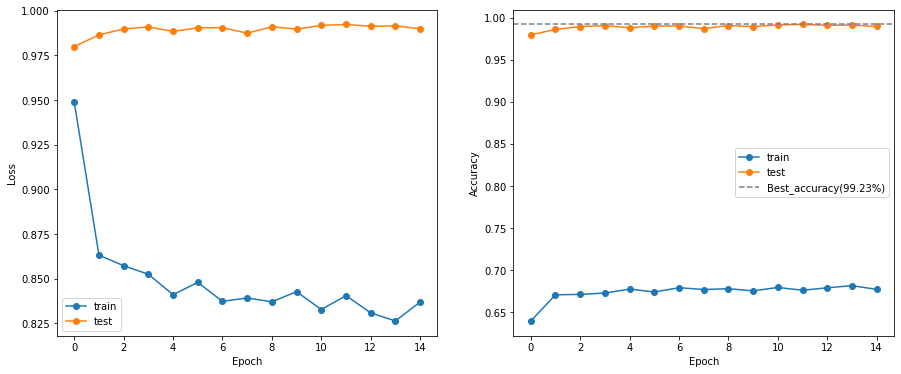

In [6]:
model.to(device)
learning_rate = 0.001
epochs = 15 

optimizer = optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.NLLLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.98
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0
    # training
    for x_train_batch, y_train_batch in trainloader:
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        optimizer.zero_grad()

        # forward pass
        logits = model(x_train_batch)
        train_preds = torch.argmax(logits.detach(), dim=1)

        # loss
        train_loss = criterion(logits, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        
        train_loss.backward()
        
        # update paramaters
        
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            x_test_batch = x_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)
            # logits
            test_logits = model(x_test_batch)

            # predictions
            test_preds = torch.argmax(test_logits, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc

            # loss
            test_loss = criterion(test_logits, y_test_batch)
            running_loss += test_loss

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_accuracy / len(testloader))
        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)
        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            # save model to cpu
            torch.save(model.to('cpu').state_dict(), './model.pth')
            model.to(device) # bring back to gpu

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./learning_curve.png', dpi = 200)

plt.show()